# Build a Retrieval Augmented Generation (RAG) App
## Part 1
### Setup

In [1]:
import yaml
import os

with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

for key in config.keys():
    os.environ[key] = config[key]

### Chat model, embeddings model and vector store

In [2]:
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

llm = init_chat_model("gpt-4o-mini", model_provider="openai")
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

### Building the vector storage
Using a `TextLoader` here, but other loaders could be used (e.g. `WebBaseLoader`).

`RecursiveCharacterTextSplitter` is used, recursively splitting the text by common characters up to the correct size. This specific text is not so big and could match the model context window but it works for bigger texts too.

In [3]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = TextLoader("./inland_empire_transcript.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

Split blog post into 35 sub-documents.


### Define application

In [4]:
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_core.documents import Document
from langchain import hub

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

### Using the app

In [5]:
response = graph.invoke({"question": "Who is the neighbor woman? What it represents?"})
print(response["answer"])

The neighbor woman is referred to as Visitor #1, who introduces herself as a new neighbor to Nikki. She represents a sense of mystery and possibly the idea of hidden truths or dangers that exist in familiar settings. Her presence and dialogue suggest themes of forgetfulness, life choices, and the darker undercurrents of seemingly normal lives.


In [6]:
print(f"Total characters: {len(docs[0].page_content)}")
print(docs[0].page_content[:500])

Total characters: 26794
(Rays of light are seen in black and white coming out of a projector. The crackling noise of an old record and loud sounds are heard in the background. We see a close-up of a vinyl record playing. A round of applause is heard.)

Narrator: Axxon N., the longest-running radio play in history: tonight, continuing in the Baltic region, a grey winter day in an old hotel.

Woman #1: Na schodach jest ciemno.

(Man #1 and Woman #1 walk down the hallway of a hotel.)

Woman #1: Nie rozpoznaję tego korytar


### Query analisis
So far, we are executing the retrieval using the raw input query. 

But we could use the model to generate the query for better queries or to use some kind of filtering.

#### Example with a filter

In [7]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

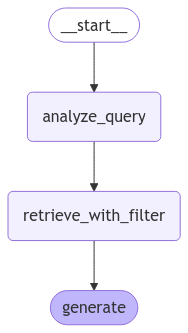

In [8]:
from typing import Literal
from IPython.display import Image, display
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]


# Define state for application
class StateWithQuery(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str



def analyze_query(state: StateWithQuery):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve_with_filter(state: StateWithQuery):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

graph_builder = StateGraph(StateWithQuery).add_sequence([analyze_query, retrieve_with_filter, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
for step in graph.stream(
    {"question": "What is the topic from the beginning of the transcript?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'topic from the beginning of the transcript', 'section': 'beginning'}}}

----------------

{'retrieve_with_filter': {'context': [Document(id='aa2b3f3e-cf1e-4303-a59c-08b336a3097f', metadata={'source': './inland_empire_transcript.txt', 'section': 'beginning'}, page_content='(Rays of light are seen in black and white coming out of a projector. The crackling noise of an old record and loud sounds are heard in the background. We see a close-up of a vinyl record playing. A round of applause is heard.)\n\nNarrator: Axxon N., the longest-running radio play in history: tonight, continuing in the Baltic region, a grey winter day in an old hotel.\n\nWoman #1: Na schodach jest ciemno.\n\n(Man #1 and Woman #1 walk down the hallway of a hotel.)\n\nWoman #1: Nie rozpoznaję tego korytarza. Gdzie my jesteśmy?\n\nMan #1: To nasz pokój.\n\nWoman #1: (looking for the key in her purse) Nie mam klucza.\n\nMan #1: Nie, nie masz. Dałaś go mnie. Ja go mam.\n\nWoman #1: Co